In [46]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import os
%matplotlib inline
from nltk.corpus import gutenberg
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.decomposition import NMF
import time

In [2]:
#List all the filenames we are looking at
filenames = ['rec.motorcycles','rec.sport.baseball','sci.space','soc.religion.christian']

In [3]:
# Getting a dictionary for each file
def get_topic(topic):
    path = 'newsgroups/{}'.format(topic)
    filelist = os.listdir(path)
    all_post = []
    
    for file in filelist:
        filepath = path+'/'+file
        text = open(filepath, encoding='latin1').read()
        all_post.append({'topic':topic,'text': text,'idno': file})
        
    df = pd.DataFrame.from_dict(all_post)
    
    return df

# Combining all the dictionaries to a master Dataframe
def get_df(topics):
    df = pd.DataFrame()
    for topic in topics:
        new_df = get_topic(topic)
        df = pd.concat([df, new_df])
    return df     

In [14]:
news = get_df(filenames)
n_top_words = 10

In [17]:
# Linking words to topics
def word_topic(tfidf,solution, wordlist):
    
    # Loading scores for each word on each topic/component.
    words_by_topic=tfidf.T * solution

    # Linking the loadings to the words in an easy-to-read way.
    components=pd.DataFrame(words_by_topic,index=wordlist)
    
    return components

def top_words(components, n_top_words):
    n_topics = range(components.shape[1])
    index= np.repeat(n_topics, n_top_words, axis=0)
    topwords=pd.Series(index=index)
    for column in range(components.shape[1]):
        # Sort the column so that highest loadings are at the top.
        sortedwords=components.iloc[:,column].sort_values(ascending=False)
        # Choose the N highest loadings.
        chosen=sortedwords[:n_top_words]
        # Combine loading and index into a string.
        chosenlist=chosen.index +" "+round(chosen,2).map(str) 
        topwords.loc[column]=chosenlist
    return(topwords)

In [27]:
# Generating topics
def gen_topics(ntopics, tfidf):
    svd= TruncatedSVD(ntopics)
    lsa = make_pipeline(svd, Normalizer(copy=False))
    news_lsa = lsa.fit_transform(tfidf)
    return news_lsa

def get_topwords(vect, tfidf, n_top_words):
    news_lsa = gen_topics(4, tfidf)
    components_lsa = word_topic(tfidf, news_lsa, terms)
    return top_words(components_lsa, n_top_words)  

In [51]:
startTime_lsa = time.time()
#Creating the tfidf matrix
vectorizer = TfidfVectorizer(lowercase=False, 
                          stop_words='english',
                          ngram_range=(1, 1), 
                          analyzer=u'word', 
                          max_df=.5, 
                          min_df=1,
                          max_features=None, 
                          vocabulary=None, 
                          binary=False)

news_tfidf = vectorizer.fit_transform(news.text)
terms = vectorizer.get_feature_names()

twords = get_topwords(vectorizer, news_tfidf, 10)
print(time.time()-startTime_lsa)

def sep_df(df):
    df = df.apply(lambda x: x.split(' '))
    new_df= pd.DataFrame()
    new_df['topword'] = df.apply(lambda x: x[0])
    new_df['score'] = df.apply(lambda x: x[1])
    return new_df

lsa_bytopic = sep_df(twords)
wordtopics = pd.DataFrame()
wordtopics['LSA'] = twords

2.5645110607147217


In [31]:
print(wordtopics)

                 LSA
0     rutgers 183.17
0    christian 96.22
0        athos 64.69
0       geneva 56.32
0          God 55.24
0          May 42.31
0     religion 41.51
0          soc 37.67
0         igor 28.85
0      hedrick 28.83
1          sci 49.72
1         space 44.7
1           ca 35.81
1         state 31.3
1         ohio 31.06
1          gov 28.38
1           EDU 27.8
1     baseball 25.82
1  motorcycles 24.34
1         nasa 23.85
2          sci 31.73
2         space 25.7
2        digex 25.62
2       access 17.96
2        astro 12.27
2       alaska 12.26
2         nasa 11.88
2          zoo 10.22
2       toronto 9.91
2           gov 9.74
3           uk 19.82
3           ac 16.24
3           ca 16.23
3          COM 13.69
3  motorcycles 13.64
3          Sun 12.89
3          bike 8.93
3           bnr 8.63
3           gov 8.52
3            sun 8.0


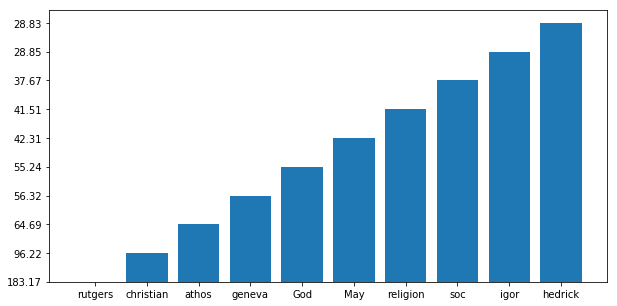

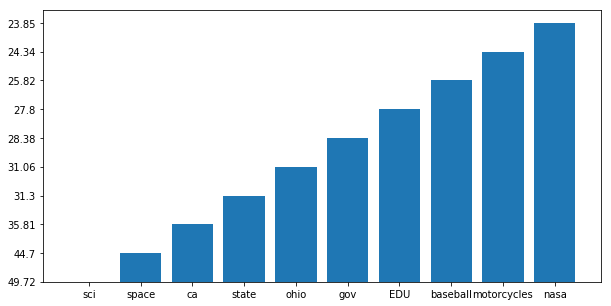

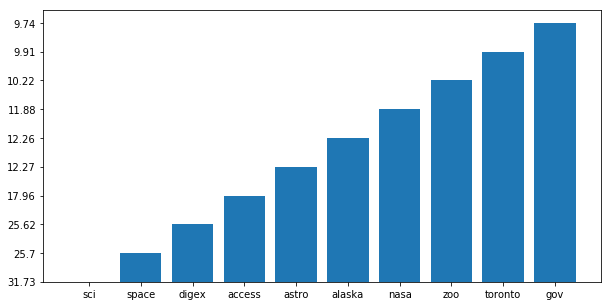

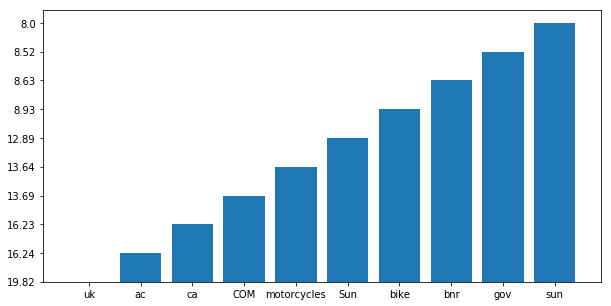

KeyError: 'the label [4] is not in the [index]'

<Figure size 720x360 with 0 Axes>

In [29]:
for i in range(39):
    plt.figure(figsize=(10,5))
    words = lsa_bytopic.loc[i,:]
    plt.bar(words.topword, words.score)
    plt.show()

In [38]:
lda = LDA(n_components=4,topic_word_prior=0.25,random_state=0)

news_lda = lda.fit_transform(news_tfidf) 

components_lda = word_topic(news_tfidf, news_lda, terms)

lda_rank = top_words(components_lda, n_top_words)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)


In [39]:
wordtopics['LDA'] = lda_rank

In [50]:
# NNMF
startTime_nnmf = time.time()
nmf = NMF(alpha=0.0, 
          init='nndsvdar', # how starting value are calculated
          l1_ratio=0.0, # Sets whether regularization is L2 (0), L1 (1), or a combination (values between 0 and 1)
          max_iter=200, # when to stop even if the model is not converging (to prevent running forever)
          n_components=4, 
          random_state=0, 
          solver='cd', # Use Coordinate Descent to solve
          tol=0.0001, # model will stop if tfidf-WH <= tol
          verbose=0 # amount of output to give while iterating
         )
news_nmf = nmf.fit_transform(news_tfidf) 

components_nmf = word_topic(news_tfidf, news_nmf, terms)

nnmf_rank = top_words(components_nmf, n_top_words)
print(time.time()-startTime_nnmf)

1.2642979621887207


In [41]:
wordtopics['NNMF'] = nnmf_rank

In [44]:
for i in range(4):
    print(wordtopics.loc[i,:])

               LSA             LDA             NNMF
0   rutgers 183.17    rutgers 4.97    rutgers 19.01
0  christian 96.22  christian 2.62  christian 10.11
0      athos 64.69        sci 1.76       athos 6.83
0     geneva 56.32      athos 1.74      geneva 5.79
0        God 55.24      state 1.56         God 5.07
0        May 42.31         ca 1.55    religion 4.32
0   religion 41.51      space 1.53         May 4.24
0        soc 37.67       ohio 1.52         soc 3.94
0       igor 28.85     geneva 1.51     hedrick 3.01
0    hedrick 28.83        God 1.27        igor 3.01
                 LSA             LDA           NNMF
1          sci 49.72     rutgers 5.0  baseball 2.35
1         space 44.7  christian 2.63        EDU 1.9
1           ca 35.81      athos 1.76      year 1.73
1         state 31.3        sci 1.75     sport 1.72
1         ohio 31.06      state 1.57      game 1.68
1          gov 28.38         ca 1.55      uiuc 1.51
1           EDU 27.8       ohio 1.53      team 1.48
1     baseba

## Summary

LDA performed the worst, showing the same words from the first group, so it is not as easy to train and separate out the texts. LSA and NNMF perform similarly, but NNMF performs faster and with less mixing between the different topics. Overall NNMF perfomrms the best out of the group on the news articles.